In [1]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import copy
import pickle
import h5py
from tensorflow.keras import backend as K
import tensorflow as tf
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from preprocess import scale_data, get_all_data, load_scalers, get_class_weights, get_datagen
from metrics import f1_m, sens_m, spec_m, g_mean_m
from model import create_model, save_weights, load_weights

In [2]:
# --------------------------- GLOBAL VARIABLES -----------------------------

train_dir = 'btc_data_extended/train_slices'
val_dir = 'btc_data_extended/val_slices'
scalers_dir = 'scalers_new'
weights_dir = 'pretrained/btcusd_trip_2'
slices = 36
x_len = 120
x_shape, y_shape = (x_len, 177), (3,)

In [3]:
# --------------------------- CALLBACKS -----------------------------

def plot_confusion_matrix():
    tfpn = {'TP':0, 'TN':1, 'FP':2, 'FN':3}
    labels = ['neutral', 'max', 'min']
    ep = 0
    cls = 1
    plt.figure(figsize=(15,9))
    for m, i in tfpn.items():
        plt.subplot(2,2,i+1)
        for cls in range(3):
            plt.plot(np.array(tfpn_history)[:, cls, i], label=labels[cls])
        plt.title(m)
        plt.legend()
    plt.show()

    
def show_confusion_matrix(epoch):
    pred = to_categorical(np.argmax(model.predict(valDataGen), axis=1), 3)
    points = [0, 1, -1]
    history = []
    for i in range(pred.shape[1]):
        pred_class = pred[:, i]
        true_pos = round(100 * sum((pred_class == 1)&(pred_class == Y_val[x_len:-1, i])) / len(pred_class[pred_class == 1]), 4)
        true_neg = round(100 * sum((pred_class == 0)&(pred_class == Y_val[x_len:-1, i])) / len(pred_class[pred_class == 0]), 4)
        false_pos = round(100 * sum((pred_class == 1)&(pred_class != Y_val[x_len:-1, i])) / len(pred_class[pred_class == 1]), 4)
        false_neg = round(100 * sum((pred_class == 0)&(pred_class != Y_val[x_len:-1, i])) / len(pred_class[pred_class == 0]), 4)
        print(f'Point {points[i]}: TP={true_pos}% , TN={true_neg}% , FP={false_pos}% , FN={false_neg}%')
        history.append([true_pos, true_neg, false_pos, false_neg])
    tfpn_history.append(history)
    plot_confusion_matrix()
    gc.collect()
    
    
def update_metrics(epoch):
    mtrc_history.append(model.evaluate(valDataGen, verbose=0))
    print('Metrics list updated')
    plot_metrics()
    
    
def plot_metrics():
    metrics = ['loss', 'acc', 'f1_m', 'g_mean_m']
    plt.figure(figsize=(15,9))
    for i in range(len(metrics)):
        plt.subplot(2,2,i+1)
        plt.plot(np.array(mtrc_history)[:, i])
        plt.title(metrics[i])
    plt.show()

    
def save_weights(path):
    model.save_weights(os.path.join(WEIGHTS_DIR, path))

    
def load_weights(path):
    model.load_weights(os.path.join(WEIGHTS_DIR, path))
    
    
def on_epoch_end(epoch, logs):
    clear_output()
    show_confusion_matrix(epoch)
    update_metrics(epoch)
    
    
info_cb = LambdaCallback(on_epoch_end=on_epoch_end)

In [4]:
scalers = load_scalers() # load pretrained scalers

In [ ]:
def train_model(start_it=0, its=5, start_slice=0, slices=slices, epochs=1):

    # start training iteration (from last checkpoint)
    for it in range(start_it, num_its):

        # make new folder for weights on current iteration
        try:
            os.mkdir(os.path.join(weights_dir, f'Epoch_{it+1}'))
        except OSError: # if it already exists
            pass

        # decrease learning rate on each epoch
        model.compile(optimizer=Adam(lr=(5-it)*(1e-4)), loss='categorical_crossentropy', metrics=['acc', f1_m, g_mean_m])

        # training model on slices (from last checkpoint)
        for i in range(start_slice, num_slices):

            train_data = pd.read_csv(os.path.join(train_dir, f's{i+1}.csv'), index_col=0) # read current slice train data
            print(f'train slice {i+1}/{slices} loaded')

            val_data = pd.read_csv(os.path.join(val_dir, f's{i+1}.csv'), index_col=0) # read current slice val data
            print(f'val slice {i+1}/{slices} loaded')

            X_train, Y_train = get_all_data(train_data, scalers, target='e_trip', categorical=True)  # get train samples
            print('train data preprocessed')

            X_val, Y_val = get_all_data(val_data, scalers, target='e_trip', categorical=True)  # get val samples
            print('val data preprocessed')

            class_weights = get_class_weights(Y_train) # count class weights to use cost-sensitive learning

            trainDataGen = get_datagen(X_train, Y_train, shuffle=False) # define train generator

            valDataGen = get_datagen(X_val, Y_val, shuffle=False) # define val generator

            model.fit(trainDataGen, epochs=epochs, class_weight=class_weights, 
                      validation_data=valDataGen, 
                      callbacks=[info_cb])  # training model 

            model.save_weights(os.path.join(weights_dir, 
                                            f'Epoch_{it+1}',
                                            f's{i+1}.h5'))  # saving weights after each epoch in case of ResourceExhaustedError

# 1st experiment
**1 iteration, 5 epochs for each slice**

In [5]:
tfpn_history = []  # TP, FP, TN, FN history
mtrc_history = []  # other metrics history
model = create_model(x_shape, y_shape, conv_size=128, dense_size=512)  # define model
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', 
              metrics=[f1_m, sens_m, spec_m, g_mean_m])  # compile

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 120, 128)          113408    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 256)           164096    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 256)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0

Point 0: TP=99.7542% , TN=10.4672% , FP=0.2458% , FN=89.5328%
Point 1: TP=10.9471% , TN=99.9002% , FP=89.0529% , FN=0.0998%
Point -1: TP=10.0228% , TN=99.8771% , FP=89.9772% , FN=0.1229%


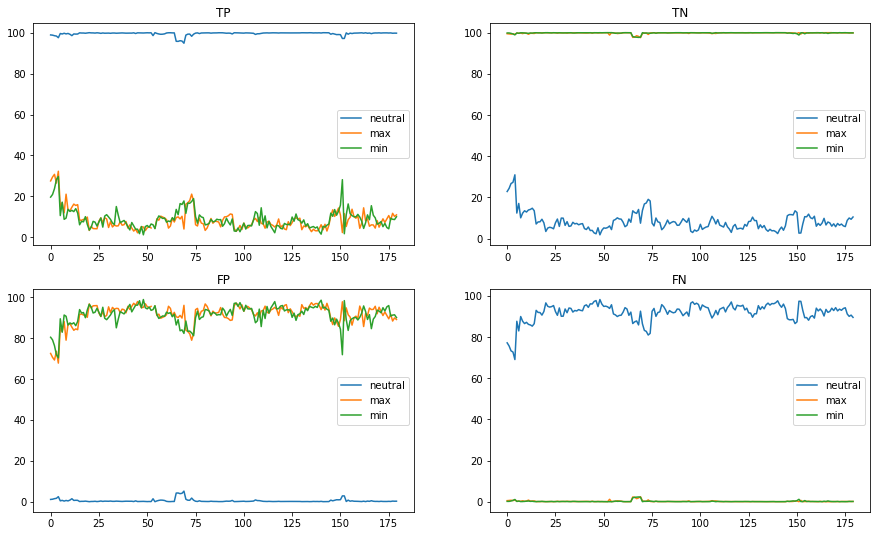

Metrics list updated


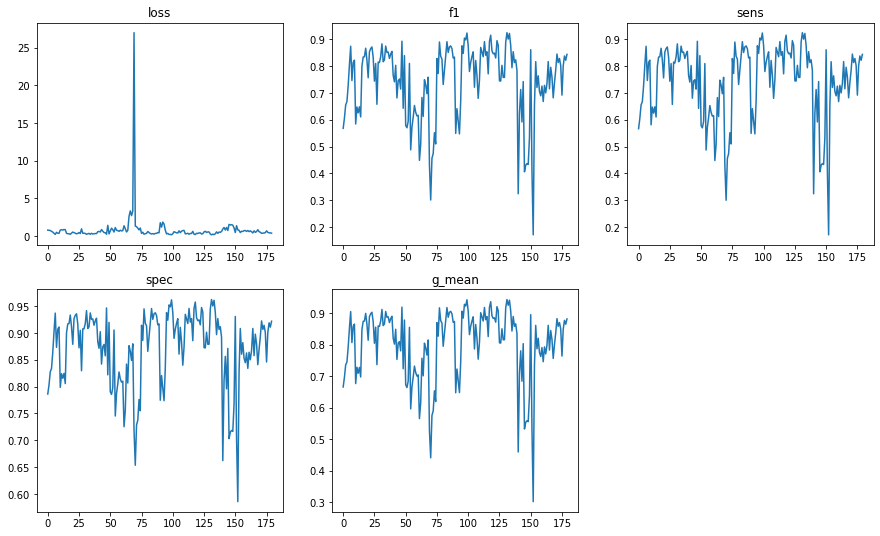


Epoch 00005: val_g_mean_m improved from 0.87698 to 0.88157, saving model to pretrained_new\s36.h5


In [17]:
train_model(num_its=1, num_epochs=5)

In [20]:
np.save('logs/tfpn_history.npy', np.array(tfpn_history))
np.save('logs/mtrc_history.npy', np.array(mtrc_history))

# 2nd experiment
**5 iterations, 1 epoch for each slice**

In [18]:
tfpn_history = []  # TP, FP, TN, FN history
mtrc_history = []  # other metrics history
model = create_model(x_shape, y_shape, conv_size=128, conv_blocks=1, dense_size=512)
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['acc', f1_m, g_mean_m])

Point 0: TP=38.1568% , TN=68.1679% , FP=61.8432% , FN=31.8321%
Point 1: TP=51.0357% , TN=74.9016% , FP=48.9643% , FN=25.0984%
Point -1: TP=51.8739% , TN=81.1314% , FP=48.1261% , FN=18.8686%


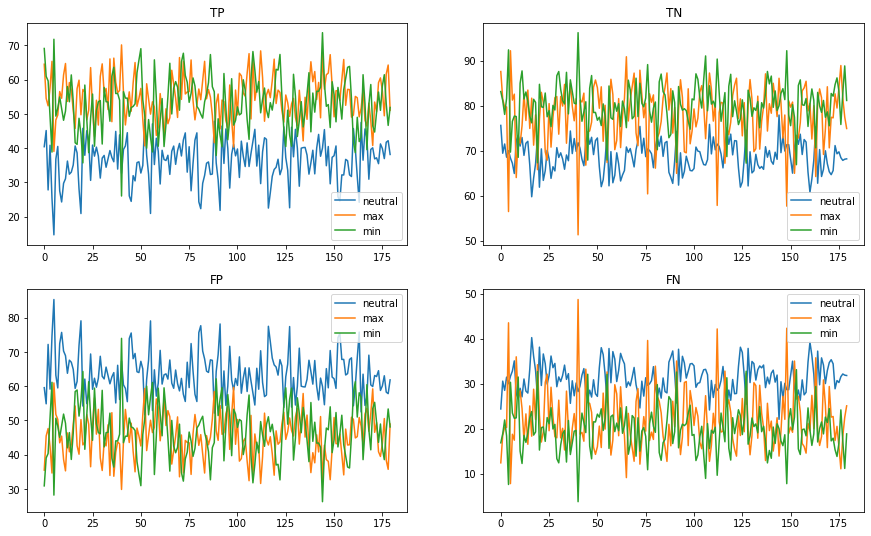

Metrics list updated


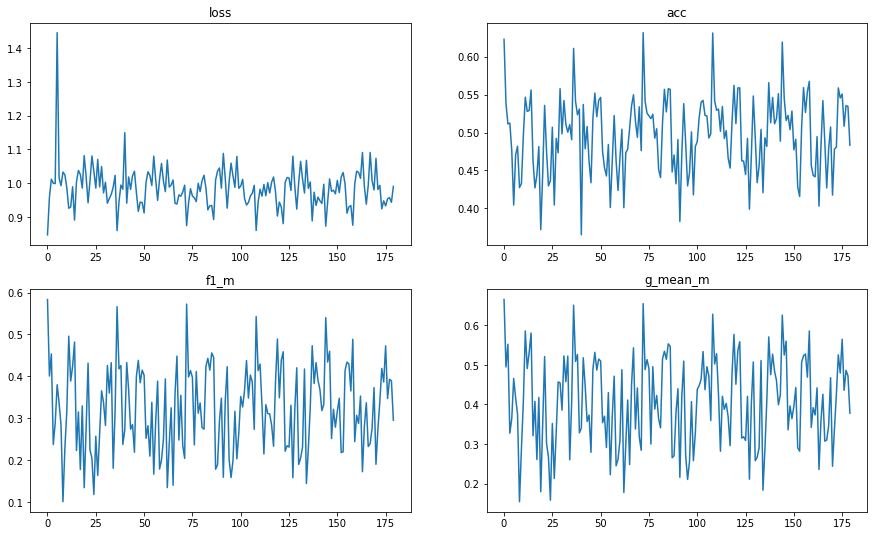

In [28]:
train_model(start_it=2, num_its=5, num_epochs=1)

In [ ]:
np.save('logs/tfpn_history_2.npy', np.array(tfpn_history))
np.save('logs/mtrc_history_2.npy', np.array(mtrc_history))

# 3rd experiment
**same as previous, but with more powerful model structure**

In [10]:
tfpn_history = []
mtrc_history = []
model = create_model(x_shape, y_shape, conv_size=128, conv_blocks=2, dense_size=1024) 

Point 0: TP=39.6825% , TN=71.1906% , FP=60.3175% , FN=28.8094%
Point 1: TP=59.6334% , TN=85.0738% , FP=40.3666% , FN=14.9262%
Point -1: TP=65.7428% , TN=82.0889% , FP=34.2572% , FN=17.9111%


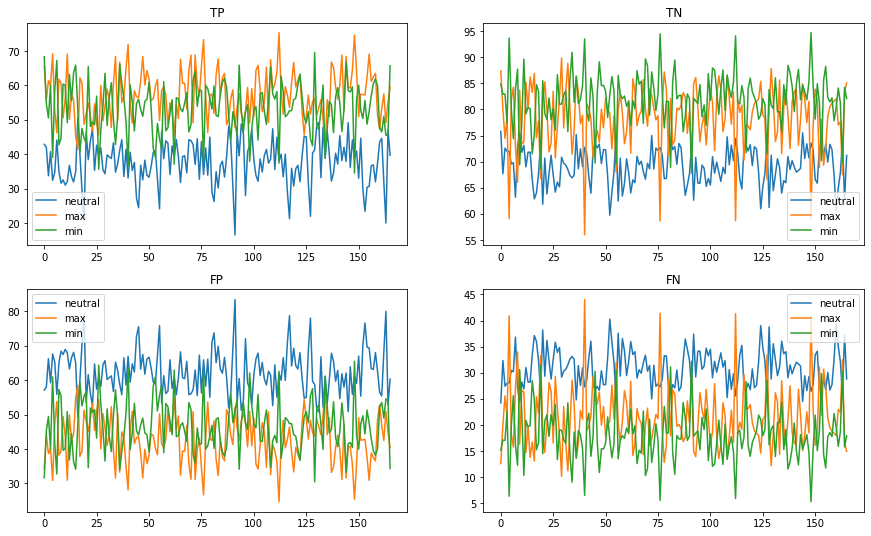

Metrics list updated


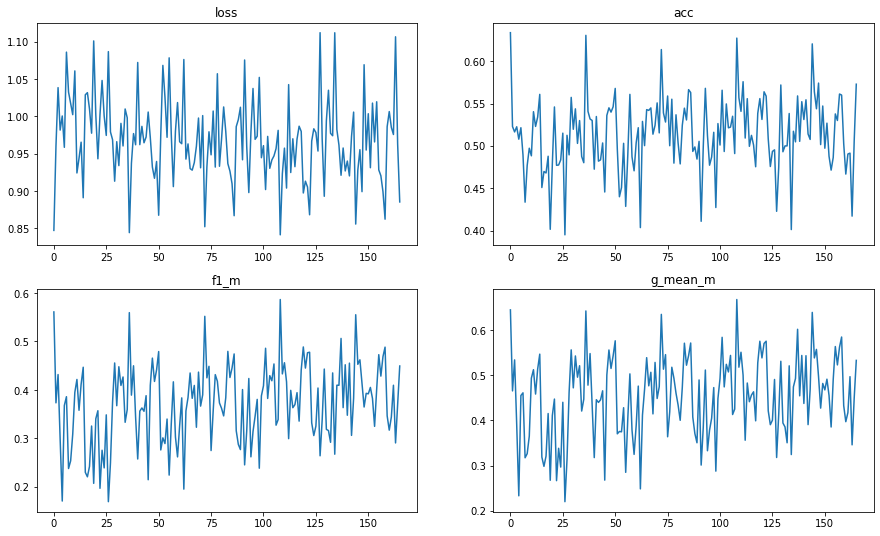

train slice 23/36 loaded
val slice 23/36 loaded
train data preprocessed
val data preprocessed
class balance: [29976. 32488. 27907.]
Data generating:  (64, 120, 177) (64, 3)
Data generating:  (64, 120, 177) (64, 3)
 592/1413 [===========>..................] - ETA: 3:49 - loss: 0.9980 - acc: 0.5491 - f1_m: 0.4180 - g_mean_m: 0.5087

ResourceExhaustedError:  OOM when allocating tensor with shape[7680,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node Adam/Adam/update_8/ResourceApplyAdam (defined at <ipython-input-15-a092904211be>:19) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1167647]

Function call stack:
train_function


In [15]:
train_model(start_it=4, num_its=5, start_slice=14, num_epochs=1)

In [ ]:
np.save('logs/tfpn_history_3.npy', np.array(tfpn_history))
np.save('logs/mtrc_history_3.npy', np.array(mtrc_history))